# Image to code generation

In [1]:
from google.colab import drive 
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
# !unzip -u '/content/drive/My Drive/purecode/Assignment_Data.zip' -d '/content/drive/My Drive/purecode/dataset'

In [3]:
import tensorflow as tf 
print(tf.__version__)
import keras
keras.__version__

2.9.2


'2.9.0'

In [4]:
# imports
import os
from os import listdir
from numpy import array
import numpy as np
import cv2
import pandas as pd

from keras.preprocessing.text import Tokenizer, one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, model_from_json
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.convolutional import Conv2D
from keras.layers import Embedding, TimeDistributed, RepeatVector, LSTM, concatenate, Input, Reshape,GRU,Bidirectional
from keras.callbacks import ModelCheckpoint
# from keras_preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt 
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [5]:
# paths for dataset
output_files= os.getcwd()+"/drive/My Drive/purecode/"
ds_train_imgs= os.getcwd()+"/drive/My Drive/purecode/dataset/D3/IMAGES/"
ds_train_labels= os.getcwd()+"/drive/My Drive/purecode/dataset/D3/TEXT_LABELS/"
# ds_val_imgs= os.getcwd()+"/drive/My Drive/purecode/dataset/D1/IMAGES/val/"
# ds_val_labels = os.getcwd()+"/drive/My Drive/purecode/dataset/D1/TEXT_LABELS/val/"
vocab_bootstrap= os.getcwd()+"/drive/My Drive/purecode/"



# Data preparation

In [6]:
all_images =[file for file in os.listdir(ds_train_imgs) if file.endswith('.png')]
all_images.sort()
print(len(all_images))
all_images[0]
len(all_images)

300


300

In [7]:
all_labels =[file for file in os.listdir(ds_train_labels) if file.endswith('.gui')]
all_labels.sort()
print(len(all_images))
all_labels[0]

300


'1007382.gui'

In [8]:
#read images and converted into numpy array
def load_images(img):  
  im = cv2.imread(img)    
  im= cv2.resize(im, (224, 224))
  return im

# read labels
def load_doc(input_label_file):
  file= open(input_label_file,'r')
  text = file.read()  
  # Load the tokens and rap them in a start and end tag
  text = ' ' + text + ' '
  # Seperate all the words with a single space
  text = ' '.join(text.split())
  # Add a space after each comma
  text = text.replace(',', ' ,')
  return text 


In [9]:
# vocablury creation
import glob
char_list = []
files_list = glob.glob(ds_train_labels+"*.gui")
files_list
for file_elem in files_list:
  char_list.append(load_doc(file_elem))
print(len(char_list))
# char_list
listToStr = ' '.join([str(elem) for elem in char_list])

voc_D3= (set(listToStr.split()))
voc_D3=' '.join(voc_D3)
print(voc_D3)

300
components { user-name logo table-row field-inactive category entry table , btns table-col user-img-user-name sidebar-left-home-right cards img-txt-btn-card sidebar field-active } btn sidebar-right-home-left logo-txt user-img logo-img img-btn-card user home img-card nav orientation


In [10]:
# load data the images with labels
def load_data(images_path, labels_path):
  images_array = []
  labels_text = []
  all_images =[file for file in os.listdir(ds_train_imgs) if file.endswith('.png')]
  all_images.sort()
  all_labels =[file for file in os.listdir(ds_train_labels) if file.endswith('.gui')]
  all_labels.sort()
  for i in range (len(all_images)): 
    images_array.append(load_images(ds_train_imgs+all_images[i]))   
    labels_text.append(load_doc(ds_train_labels+all_labels[i]))
  images_array = np.array(images_array, dtype=np.dtype('float'))   
  images_array = preprocess_input(images_array)    
  return images_array,labels_text




In [11]:
# converting image and text
img_array,img_labels=load_data(ds_train_imgs, ds_train_labels)

#Saving images and labels
df = pd.DataFrame(img_labels, columns=['text_labels_D3']) 
df.to_csv(output_files+"text_labels_list_D3.csv")
np.save(output_files+'images_array_D3', img_array)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, test_size=0.05, random_state=42)

In [32]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((285, 224, 224, 3), 285, (15, 224, 224, 3), 15)

In [33]:
img_array.shape, len(img_labels)

((300, 224, 224, 3), 300)

In [34]:
# img_array[0]

'components { sidebar , home } orientation { sidebar-left-home-right } sidebar { user { user-img } nav { field-inactive , field-inactive , field-active } logo { logo-img } } home { cards { img-card , img-txt-btn-card , img-card } table { btns { btn } table-col { category , category } table-row { entry } } }'

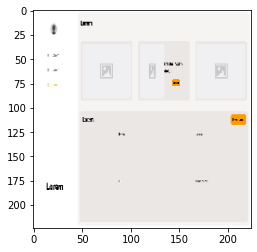

In [35]:
plt.imshow(img_array[0,:,:,:].astype('uint8'))
img_labels[0]

'components { home , sidebar } orientation { sidebar-right-home-left } home { table { btns { btn , btn , btn } table-col { category , category , category } table-row { entry } } cards { img-btn-card , img-btn-card , img-txt-btn-card } } sidebar { nav { field-inactive , field-inactive , field-active , field-inactive } user { user-name } }'

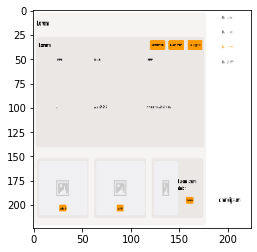

In [36]:
plt.imshow(X_test[0,:,:,:].astype('uint8'))
y_test[0]

['components', '{', 'sidebar', ',', 'home', '}', 'orientation', '{', 'sidebar', '-', 'left', '-', 'home', '-', 'right', '}', 'sidebar', '{', 'logo', '{', 'logo', '-', 'img', '}', 'nav', '{', 'field', '-', 'inactive', ',', 'field', '-', 'inactive', ',', 'field', '-', 'active', '}', 'user', '{', 'user', '-', 'name', '}', '}', 'home', '{', 'table', '{', 'btns', '{', 'btn', '}', 'table', '-', 'col', '{', 'category', ',', 'category', ',', 'category', '}', 'table', '-', 'row', '{', 'entry', ',', 'entry', ',', 'entry', ',', 'entry', '}', '}', 'cards', '{', 'img', '-', 'card', ',', 'img', '-', 'btn', '-', 'card', ',', 'img', '-', 'txt', '-', 'btn', '-', 'card', '}', '}']


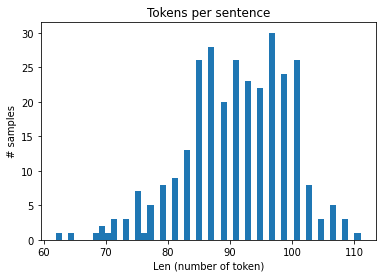

In [37]:
import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

print(tokenize(img_labels[1]))
# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in img_labels], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')

plt.ylabel('# samples')
plt.show()

In [38]:
# Initialize the function to create the vocabulary 
tokenizer = Tokenizer(filters='', split=" ", lower=False)
# Create the vocabulary 
tokenizer.fit_on_texts([load_doc(vocab_bootstrap+'bootstrap_D3.vocab')])

# Add one spot for the empty word in the vocabulary 
VOCAB_SIZE = len(tokenizer.word_index) + 1


In [39]:
tokenizer.word_index 

{'<START>': 1,
 ',': 2,
 '{': 3,
 '}': 4,
 'field-active': 5,
 'btns': 6,
 'sidebar-left-home-right': 7,
 'nav': 8,
 'home': 9,
 'entry': 10,
 'btn': 11,
 'table-row': 12,
 'components': 13,
 'img-btn-card': 14,
 'img-txt-btn-card': 15,
 'table-col': 16,
 'table': 17,
 'user-img': 18,
 'cards': 19,
 'img-card': 20,
 'category': 21,
 'user': 22,
 'orientation': 23,
 'sidebar': 24,
 'user-img-user-name': 25,
 'logo-txt': 26,
 'sidebar-right-home-left': 27,
 'field-inactive': 28,
 'user-name': 29,
 'logo-img': 30,
 'logo': 31,
 '<END>': 32}

In [40]:
#preprocessing the data
def preprocess_data(texts, images, max_sequence, MAX_lEN=50):
    X, y, image_data = list(), list(), list()
    sequences = tokenizer.texts_to_sequences(texts)
    for img_no, seq in enumerate(sequences):
        for i in range(1, len(seq)):
            # Add the sentence until the current count(i) and add the current count to the output
            in_seq, out_seq = seq[:i], seq[i]
            # Pad all the input token sentences to max_sequence
            in_seq = pad_sequences([in_seq], maxlen=max_sequence)[0]
            # Turn the output into one-hot encoding
            out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]
            # Add the corresponding image to the boostrap token file
            image_data.append(images[img_no])
            # Cap the input sentence to MAX_LEN tokens and add it
            MAX_LEN=50
            X.append(in_seq[-MAX_LEN:])
            y.append(out_seq)
    return np.array(image_data), np.array(X), np.array(y)

In [41]:
# Data generator, call to model.fit_generator()
def data_generator(descriptions, features, n_step, max_sequence, MAX_LEN):
    # loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        for i in range(0, len(descriptions), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(descriptions), i+n_step)):
                image = features[j]
                # retrieve text input
                desc = descriptions[j]
                # Generate input-output pairs
                in_img, in_seq, out_word = preprocess_data([desc], [image], max_sequence,MAX_LEN)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)]

#Model

In [42]:
# Load the EfficientNetB0 model trained on imagenet and output the classification feature
effnet = EfficientNetB0(weights='imagenet', include_top=True)

# Extract the features from the train images
features= effnet.predict(X_train)

# Extract the features from the test images
features_test = effnet.predict(X_test)

print(features.shape)
print(features_test.shape)

1/1 [==============================] - 1s 1s/step
(285, 1000)
(15, 1000)


In [46]:
MAX_SEQUENCE =150  # The max sequence to predict
MAX_lEN =50     # Max number of token for the input in the context prediction
# Load the feature to the network, apply a dense layer, and repeat the vector
eff_feature = Input(shape=(1000,))
eff_feature_dense = Dense(64)(eff_feature)
eff_feature_repeat = RepeatVector(MAX_lEN)(eff_feature_dense)

# Extract information from the input seqence 
#Create the Text-encoder
language_input = Input(shape=(50,))
language_model = Embedding(VOCAB_SIZE, 50, input_length=MAX_lEN, mask_zero=True)(language_input)
language_model = (LSTM(128, return_sequences=True))(language_model)
language_model = (LSTM(128, return_sequences=True))(language_model)


In [47]:
# Concatenate the information from the image and the input
decoder = concatenate([eff_feature_repeat, language_model])
# Extract information from the concatenated output
decoder = (LSTM(64, return_sequences=False))(decoder)
# Predict which word comes next
decoder_output = Dense(VOCAB_SIZE, activation='softmax')(decoder)
# Compile and run the neural network
model = Model(inputs=[eff_feature, language_input], outputs=decoder_output)
optimizer= Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer) #rmsprop

In [48]:
# Train the neural network
MAX_SEQUENCE=150
batch_size =64
history= model.fit(data_generator(y_train, features, 1, MAX_SEQUENCE,MAX_LEN=50), steps_per_epoch=len(y_train)//batch_size, batch_size=batch_size, shuffle=False, epochs=1500,verbose=1)

Epoch 1/1500
4/4 [==============================] - 13s 409ms/step - loss: 3.4721
Epoch 2/1500
4/4 [==============================] - 2s 386ms/step - loss: 3.2412
Epoch 3/1500
4/4 [==============================] - 2s 387ms/step - loss: 2.9485
Epoch 4/1500
4/4 [==============================] - 2s 382ms/step - loss: 2.8389
Epoch 5/1500
4/4 [==============================] - 2s 422ms/step - loss: 2.7791
Epoch 6/1500
4/4 [==============================] - 2s 380ms/step - loss: 2.8220
Epoch 7/1500
4/4 [==============================] - 2s 396ms/step - loss: 2.7917
Epoch 8/1500
4/4 [==============================] - 1s 360ms/step - loss: 2.7461
Epoch 9/1500
4/4 [==============================] - 2s 389ms/step - loss: 2.7517
Epoch 10/1500
4/4 [==============================] - 2s 375ms/step - loss: 2.7483
Epoch 11/1500
4/4 [==============================] - 1s 366ms/step - loss: 2.7330
Epoch 12/1500
4/4 [==============================] - 2s 382ms/step - loss: 2.7092
Epoch 13/1500
4/4 [=====

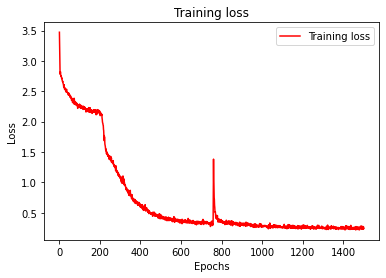

In [49]:
# Plotting training and validation loss for combined model
loss_values = history.history['loss']
# val_loss_values = history.history['val_loss']
epochs = range(1, len(history.history['loss'] )+ 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
# plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("D3_model_loss.png")
plt.show()

In [50]:
#Save the model for every 2nd epoch
model.save(output_files+'pic2text_model_D3.h5')  # creates a HDF5 file 'my_model.h5'

# Evaluate model

In [51]:
from keras.saving.save import load_model
model= load_model(output_files+'pic2text_model_D3.h5')

In [52]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    photo = np.array([photo])
    # seed the generation process
    in_text = ' '
    # iterate over the whole length of the sequence
    print('\nPrediction---->\n\n ', end='')
    for i in range(150):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += word + ' '
        # stop if we predict the end of the sequence
        print(word + ' ', end='')
        if word == '':
            break
    return in_text

In [53]:
from nltk.translate.bleu_score import corpus_bleu

# Evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for i in range(len(descriptions)):
        yhat = generate_desc(model, tokenizer, photos[i], max_length)
        # store actual and predicted
        print('\n\nReal---->\n\n' + y_test[i])
        actual.append([y_test[i].split()])
        predicted.append(yhat.split())
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted)
    return bleu, actual, predicted

# Eval on the first 10 samples
# bleu, actual, predicted = evaluate_model(model, texts[:10], train_features[:10], tokenizer, MAX_LEN)
bleu, actual, predicted = evaluate_model(model, y_test, features_test, tokenizer, 50)
print("BLUE score: ", bleu)


Prediction---->

 } { home , home , btn } } home { cards { img-btn-card , img-txt-btn-card , img-txt-btn-card } table { btns { btn , btn , btn } table-col { category , category , category } table-row { entry , entry , entry , entry } } } sidebar { nav { field-active , field-inactive , field-inactive , field-inactive } logo { logo-img } user { user-img-user-name } } home { cards { img-btn-card , img-txt-btn-card , img-txt-btn-card } table { btns { btn , btn , btn } table-col { category , category , category } table-row { entry , entry , entry , entry } } } sidebar { nav { field-active , field-inactive , field-inactive , field-inactive } logo { logo-img } user { user-img-user-name } } home { cards { img-btn-card , img-txt-btn-card , img-txt-btn-card } table { btns { btn , btn , btn 

Real---->

components { home , sidebar } orientation { sidebar-right-home-left } home { table { btns { btn , btn , btn } table-col { category , category , category } table-row { entry } } cards { img-btn-ca